In [4]:
import pandas as pd
import os, glob, sys
import sklearn , datetime, pickle

In [5]:
os.environ['PROJECT_DIR'] = "C:\\Users\\581686284\\PycharmProjects\\Automated_Ticket_Management-2\\"
os.environ['SM9_TRAINING_DATA'] = "rawdata\\sm9\\train\\*.csv"
os.environ['SM9_TRAINING_DATA_EXCEL'] = "rawdata\\sm9\\train_excel\\*.xlsx"
os.environ['SM9_TEST_DATA'] = "rawdata\\sm9\\test\\*.csv"
os.environ['SM9_TEST_DATA_EXCEL'] = "rawdata\\sm9\\test_excel\\*.xlsx"
os.environ['SERVICE_NOW_TRAINING_DATA'] = "rawdata\\serviceNow\\train\\*.csv"
os.environ['SERVICE_NOW_TRAINING_DATA_EXCEL'] = "rawdata\\serviceNow\\train_excel\\*.xlsx"
os.environ['SERVICE_NOW_TEST_DATA'] = "rawdata\\serviceNow\\test\\*.csv"
os.environ['SERVICE_NOW_TEST_DATA_EXCEL'] = "rawdata\\serviceNow\\test_excel\\*.xlsx"
os.environ['RECOMMENDATIONS'] = "recommendations\\"

In [6]:
sm9_files = glob.glob(os.environ['PROJECT_DIR'] + os.environ['SM9_TRAINING_DATA_EXCEL'])

# sm9_columns is declared, but not included when reading sm9_data_list, as Client Base value is nan for some tickets
# & read_csv does not like that. Hence not specifying sm9_columns when reading csv. 'Close Date' tells us which csv file 
# has the ticket. Ticket are organized based on close date. So , a ticket might be created in January, but close in August, would
# be included in August csv. 

sm9_columns = ['Assigned Dept', 'Assigned to', 'Number','RBC Line Item Title', 'RBCMMPRITM', 'Rbc Description', 'Client Base']

#sm9_data_list = [ pd.read_csv(sm9_file , encoding='latin-1' , usecols=sm9_columns ) for sm9_file in sm9_files ]
sm9_data_list = [ pd.read_excel(sm9_file) for sm9_file in sm9_files ]
sm9_data = pd.concat(sm9_data_list)
sm9_data = sm9_data[sm9_columns]
sm9_data = sm9_data.reset_index(drop=True)
sm9_data.shape

(373603, 7)

In [7]:
# import datetime
# now=datetime.datetime.now()
# now.isoformat()

# os.environ['PROJECT_DIR'] = "C:\\Users\\581686284\\PycharmProjects\\Automated_Ticket_Management-2\\"
# os.environ['SM9_TRAINING_DATA'] = "rawdata\\sm9\\train\\*.csv"
# os.environ['SM9_TEST_DATA'] = "rawdata\\sm9\\test\\*.csv"
# os.environ['SERVICE_NOW_TRAINING_DATA'] = "rawdata\\serviceNow\\train\\*.csv"
# os.environ['SERVICE_NOW_TEST_DATA'] = "rawdata\\serviceNow\\test\\*.csv"
# os.environ['RECOMMENDATIONS'] = "recommendations\\"

# filename = os.environ['PROJECT_DIR'] + os.environ['RECOMMENDATIONS'] + "tickets_recommendation_" + datetime.datetime.now().isoformat() + ".csv"
# filename

In [8]:
# Utility Function. Convert objects to int. Required for Assigned to column, which has float values for employee id. 
# This function helps fix that 

def object_to_int(x):
    try:
        return int(x)
    except ValueError:
        return 123
    
# os.environ['PROJECT_DIR'] = "C:\\Users\\581686284\\PycharmProjects\\Automated_Ticket_Management-2\\"
# os.environ['SM9_TRAINING_DATA'] = "rawdata\\sm9\\train\\*.csv"
# os.environ['SM9_TEST_DATA'] = "rawdata\\sm9\\test\\*.csv"
# os.environ['SERVICE_NOW_TRAINING_DATA'] = "rawdata\\serviceNow\\train\\*.csv"
# os.environ['SERVICE_NOW_TEST_DATA'] = "rawdata\\serviceNow\\test\\*.csv"

# Current Team List

In [9]:

# Get Team List
team_data_columns = ['Name','Status','Employee #','Windows & Appliciation (Line of Business) Skillset']
team_sheet = pd.read_excel(os.environ['PROJECT_DIR'] + 'rawdata\\Team List.xlsx' , header=1 , usecols = team_data_columns, index_col = 2)
team_sheet_without_leads = team_sheet.loc[team_sheet['Status'] != 'FTE Team Lead']
analyst_emp_id = team_sheet_without_leads.index.tolist()
team_sheet_without_leads

# from collections import Counter
# Counter(analyst_emp_id)

,Name,Status,Windows & Appliciation (Line of Business) Skillset
Employee #,,,
191918473,"Aberin, Mario",FTE TSA,"Windows, Change Records, Applications: Some In..."
329338909,"Das, Animesh",Co-op,Windows
319749875,"Chohan, Sophia",FTE TSA,"Applications: PH&N, DS"
311145288,"Chaudry, Arusha",Co-op,NaN
856895107,"Liu, Chen C",Co-op,See Co-op Team Captain
184831246,"Cai, Charlotte",Co-op,See Co-op Team Captain
330086414,"Jaswal, Aman",Co-op,See Co-op Team Captain
328874185,"de Loyola, Krizia",FTE TSA,"Windows, Applications: DS"
648708485,"Deschenes, Sylvia",FTE TSA,Disable Windows ID; ADD-P; create app group; c...


In [10]:
# Get Employee Id from Name 
emp_id = (team_sheet_without_leads.loc[team_sheet_without_leads['Name'] == 'Aberin, Mario']).index.tolist()

In [11]:
# Get Employee Id from Name 
name = team_sheet_without_leads.loc[191918473]['Name'] 

# Teams 

In [12]:
import pandas as pd
analyst_teams = pd.read_excel(os.environ['PROJECT_DIR'] + 'rawdata\\Global 2018 Operations Schedule.xlsx', sheetname='MONTHLY SCHEDULE', header = 2 , index_col=0)
analyst_teams

,# Analysts required,January,Febuary,March,April,May,June,July,August,September,October,November,Dec,Unnamed: 13
Late,2.0,"Sandhawalia, Soby","Lilbourne, Lauren","Patel, Rita","Kadoura, Zaki","Gibbons, Paul","Feta, Samir","Huston, Virgilia","Kadoura, Zaki","MariaFrancis, Jennifia","Papagiannidis, Kostas","Mostoles, Sherylle","Swaby, Oraine",NaN
NaN,NaN,"Jette, Christopher","Jereza, Agustin","McQuarrie, Katrina","Feta, Samir","Aberin, Mario","Sandhawalia, Soby",Mario /Kostas,"Shah, Rohan","McQuarrie, Katrina","Shah, Rohan","Aberin, Mario","Patel, Rita",NaN
Early,1.0,"McQuarrie, Andrew","Stone, Randall","MacLellan, Jon","McQuarrie, Katrina","Tompkins, Kevin","Deschenes, Sylvia","MacLellan, Jon","McQuarrie, Katrina","Tompkins, Kevin","McQuarrie, Andrew","Deschenes, Sylvia","Stone, Randall",NaN
Mailbox/ Passwords,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,* See daily schedule
Windows,12.0,NaN,"Jamal, Sarah","Stone, Randall","Huston, Virgilia","McQuarrie, Katrina *","Stone, Randall","Stone, Randall","Deschenes, Sylvia","Stone, Randall","Stone, Randall","Huston, Virgilia","McQuarrie, Katrina",NaN
NaN,NaN,NaN,"Deschenes, Sylvia","McQuarrie, Andrew","Stone, Randall","Papagiannidis, Kostas","MacLellan, Jon","Tompkins, Kevin","Huston, Virgilia","Gibbons, Paul","MacLellan, Jon","Tompkins, Kevin","Tompkins, Kevin",NaN
NaN,NaN,NaN,Ryan,"Lilbourne, Lauren","Deschenes, Sylvia","Jereza, Agustin",Lauren,"Papagiannidis, Kostas","Tompkins, Kevin","Aberin, Mario","Deschenes, Sylvia","McQuarrie, Andrew","Gibbons, Paul",NaN
NaN,NaN,NaN,"MacLellan, Jon","Deschenes, Sylvia","Sandhawalia, Soby","Patel, Rita","Aberin, Mario","Lilbourne, Lauren","McQuarrie, Andrew","Jereza, Agustin","Sandhawalia, Soby","Sandhawalia, Soby","Sandhawalia, Soby",NaN
NaN,NaN,NaN,"Papagiannidis, Kostas","Papagiannidis, Kostas","Jereza, Agustin","Lilbourne, Lauren","Patel, Rita","Kadoura, Zaki","Sandhawalia, Soby","Patel, Rita","Mostoles, Sherylle","Papagiannidis, Kostas","Aberin, Mario",NaN
NaN,NaN,NaN,"Sandhawalia, Soby","Aberin, Mario","Mostoles, Sherylle","Kadoura, Zaki","Swaby, Oraine","Swaby, Oraine","Aberin, Mario","Shah, Rohan","McQuarrie, Katrina","Jereza, Agustin","Papagiannidis, Kostas",NaN


In [13]:
# This gives all the teams we have. This would be used to get team members
team_name = []
team_index = analyst_teams.index.tolist()
for t in team_index:
    if type(t) is str:
        team_name.append(t)
print(team_name)

['Late', 'Early', 'Mailbox/ Passwords', 'Windows', 'Dominion Securities, E&T, PH&N', 'Wealth Management, Direct Investing, Capital Markets, Head Office', 'CDN I&TS', 'Insurance', 'Cards & Payments, RBC Bank', 'UK I&TS', 'Caribbean', 'UK Wealth Mgmt', 'US PCG', 'US Corp', 'US CAS', 'Total']


In [14]:
# Get the month for which we want the team for . 
from datetime import datetime
current_month = datetime.now().strftime('%B') # 'August'

In [15]:
team_list = {} # Dictionary of team name as key & team mates as value. 

for t in range(len(team_name) - 1):
    team = analyst_teams.loc[team_name[t]:team_name[t+1] , current_month]
    team = team.iloc[:len(team) - 1]
    team.reset_index(drop=True,inplace=True)
    team = team.loc[~team.isnull()]
    team = team[:len(team)]
    team_list[team_name[t]] = team

team_list

{'CDN I&TS': 0    MacLellan, Jon 
 1     Stone, Randall
 Name: August, dtype: object,
 'Cards & Payments, RBC Bank': 0    Mostoles, Sherylle
 1    Jette, Christopher
 Name: August, dtype: object,
 'Caribbean': 0            King, Sancha
 1    Dubissette, Donnette
 2          Dookie, Pamela
 3      Adderley, Nikeisha
 4        Fonrose, Sadicki
 Name: August, dtype: object,
 'Dominion Securities, E&T, PH&N': 0     Papagiannidis, Kostas
 1            Chohan, Sophia
 2         Lilbourne, Lauren
 3    MariaFrancis, Jennifia
 Name: August, dtype: object,
 'Early': 0    McQuarrie, Katrina
 Name: August, dtype: object,
 'Insurance': 0      Gibbons, Paul
 1    Jereza, Agustin
 Name: August, dtype: object,
 'Late': 0    Kadoura, Zaki
 1      Shah, Rohan
 Name: August, dtype: object,
 'Mailbox/ Passwords': Series([], Name: August, dtype: object),
 'UK I&TS': Series([], Name: August, dtype: object),
 'UK Wealth Mgmt': 0     Johnston, Dan
 1    Hardisty, Erin
 2       Wrona, Anna
 3     Dorney, Niam

# Client Base to Teams Mapping



In [16]:
client_base_to_team = pd.read_excel(os.environ['PROJECT_DIR'] + 'rawdata\\Client_Base_to_Team_Mapper.xlsx',index_col=0)
client_base_to_team

,ESAM Application Teams
Client Base,
Technology & Operations,"Cards & Payments, RBC Bank | Dominion Securiti..."
Insurance,Insurance
Wealth Management - Non US,"Dominion Securities, E&T, PH&N | Wealth Manage..."
Investor & Treasury Services,CDN I&TS | UK I&TS
Personal & Commercial Banking (Canadian),"Cards & Payments, RBC Bank"
Wealth Management,"Dominion Securities, E&T, PH&N | Wealth Manage..."
Capital Markets IT & Operations,"Dominion Securities, E&T, PH&N | Wealth Manage..."
Group Risk Management,All
Office of the CAO & CFO,All


In [17]:
# client_base_to_team.loc[client_base_to_team['Client Base'] == 'Technology & Operations']

# ((client_base_to_team.loc['Technology & Operations']).tolist())[0].split(',')

# esam_team_series = client_base_to_team.loc['Technology & Operations']
# esam_team_series.get_values()

# client_base_to_team

# Vacation Schedule

In [18]:
# Get Vacation Schedule 

all_vacation = pd.read_excel(os.environ['PROJECT_DIR'] + 'rawdata\\Vacation Calendar 2018.xlsx', sheetname='All', index_col=0)
all_vacation.columns = list(range(1,32))
all_vacation.head()

,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
JANUARY 2018,,,,,,,,,,,,,,,,,,,,,
NaN,1.0,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29.0,30.0,31
Management,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Mickle, Cory",0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
"Gueli, Maria",0.0,L,L,L,L,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
"Ramesh, Shantie",0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0


In [19]:
# Get the month & year. This would be used to get vacation information for the corresponding month and year. 
from datetime import datetime
current_month = datetime.now().strftime('%B') # 'August'
current_year = datetime.now().strftime('%Y')  # 2018
month_year = (current_month + ' ' + str(current_year)).upper()
#month_year = 'December 2018'
print("From : " , month_year)

# Get next month year. If current month is December , then set next_month_year to empty
from dateutil import relativedelta
next_month_year = ''
# Make sure the year in the below condition is a variable. What if the year is December 2019. Then the below code would fail. 
if month_year != 'December 2018':
    #nextmonth = datetime.date.today() + relativedelta.relativedelta(months=1)
    nextmonth = datetime.now() + relativedelta.relativedelta(months=1)
    next_month = nextmonth.strftime('%B')
    next_month_year = (next_month + ' ' + current_year).upper()
else:
    # What if the month year is December 2018
    # In this case you would use the current month_year variable.
    pass

print("To : " , next_month_year)    

From :  AUGUST 2018
To :  SEPTEMBER 2018


In [20]:
# Get Vacation Schedule for the current month 

vc = all_vacation.loc[month_year : next_month_year ]
vc

,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
JANUARY 2018,,,,,,,,,,,,,,,,,,,,,
AUGUST 2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,1.0,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29.0,30.0,31
Management,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Mickle, Cory",0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
"Gueli, Maria",0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
"Ramesh, Shantie",0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
"Maughan, Kevin",0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
"Amir, Nadia",0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
TOTAL,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0


In [21]:
# Based on current day & the analyst name, check if the analyst is on a vacation. 
current_day = datetime.now().strftime('%d')
print(current_day)
analyst_name = 'Papagiannidis, Kostas'
if vc.loc[analyst_name][13] == 7.5 : 
    print("Yes")

22
Yes


# Availability

In [22]:
# Get all tickets in an analyst's queue. 

availability_columns = ['Assigned to','Pending Customer','Client Base']
availability = pd.read_csv("C:\\Project\\Data\\availability.csv" , encoding='latin-1' , usecols=availability_columns )
availability = availability.loc[~availability['Assigned to'].isnull()]
availability['Pending Customer'] = availability['Pending Customer'].fillna('FALSE')
availability['Assigned to'] = availability['Assigned to'].apply(object_to_int)
availability.loc[availability['Assigned to'].isin(['310294822'])]

,Assigned to,Pending Customer,Client Base
4,310294822,TRUE,Capital Markets IT & Operations
13,310294822,TRUE,Wealth Management - Non US
14,310294822,TRUE,Technology & Operations
16,310294822,TRUE,Wealth Management - Non US
17,310294822,TRUE,Wealth Management - Non US
19,310294822,TRUE,Wealth Management - Non US
55,310294822,FALSE,Group Risk Management
56,310294822,TRUE,Technology & Operations
71,310294822,TRUE,Wealth Management - Non US
72,310294822,TRUE,Technology & Operations


In [23]:
availability_grouped = availability.groupby(['Assigned to','Pending Customer']).count()
availability_grouped.rename(columns = {'Client Base' : 'No_of_Tickets_Assigned'} , inplace=True)
availability_grouped

No_of_Tickets_Assigned
Assigned to Pending Customer                        
178412342   FALSE                                 11
            TRUE                                  34
180190019   FALSE                                 17
            TRUE                                  25
184831246   FALSE                                  1
            TRUE                                  33
191458827   FALSE                                 19
            TRUE                                   2
195808886   FALSE                                  1
            TRUE                                   1
291180362   FALSE                                 14
            TRUE                                   5
294555602   TRUE                                   2
296472020   FALSE                                  7
            TRUE                                   5
310294822   FALSE                                 17
            TRUE                                  13
311145288   FALSE                                  6
            TRUE                                  10
312363658   TRUE                                   1
319749875   FALSE                                 16
            TRUE                                   2
324653500   FALSE                                 32
            TRUE                                  10
326291085   FALSE                                 28
            TRUE                                  15
328453238   FALSE                                 39
            TRUE                                  11
328728829   FALSE                                 14
            TRUE                                   9
...                                              ...
535902738   TRUE                                   1
543589881   TRUE                                   1
544269145   FALSE                                  2
            TRUE                                  11
631444387   FALSE                                 10
            TRUE                                  18
648708485   FALSE                                105
            TRUE                                  47
662377118   FALSE                                  1
698544350   FALSE                                 22
            TRUE                                   8
776883118   FALSE                                  9
            TRUE                                   4
787489756   FALSE                                 35
            TRUE                                   4
803530104   TRUE                                   1
848792669   TRUE                                   1
850097346   FALSE                                  4
856836887   FALSE                                  5
            TRUE                                   1
856895107   FALSE                                  5
            TRUE                                  31
858410889   FALSE                                  4
            TRUE                                   4
859476285   FALSE                                  7
            TRUE                                   1
936531946   FALSE                                 13
            TRUE                                   5
956519110   FALSE                                  1
            TRUE                                   1

[82 rows x 1 columns]

In [24]:
# Get Current Roaster 
import os
os.environ['PROJECT_DIR'] = "C:\\Users\\581686284\\PycharmProjects\\Automated_Ticket_Management-2\\"
# Get Team List
team_data_columns = ['Name','Status','Employee #','Windows & Appliciation (Line of Business) Skillset']
team_sheet = pd.read_excel(os.environ['PROJECT_DIR'] + 'rawdata\\Team List.xlsx' , header=1 , usecols = team_data_columns, index_col = 2)
team_sheet_without_leads = team_sheet.loc[team_sheet['Status'] != 'FTE Team Lead']
analyst_emp_id = team_sheet_without_leads.index.tolist()
analyst_emp_id

[191918473,
 329338909,
 319749875,
 311145288,
 856895107,
 184831246,
 330086414,
 328874185,
 648708485,
 848792669,
 535506877,
 776883118,
 314884594,
 787489756,
 668401755,
 329808695,
 544269145,
 330086414,
 522079805,
 698544350,
 521307710,
 310294822,
 291180362,
 631444387,
 191458827,
 956519110,
 936531946,
 312363658,
 535902738,
 850772930,
 535567176,
 318215316,
 328453238,
 180190019,
 324653500,
 178412342,
 311485742]

In [25]:
len(analyst_emp_id)
tickets_analyst_queue = {}
for analyst in analyst_emp_id:
    try:
        tickets_analyst_queue[analyst] = availability_grouped.loc[(analyst,'FALSE')]['No_of_Tickets_Assigned']
    except Exception as e:
        print(e)
        tickets_analyst_queue[analyst] = 0
tickets_analyst_queue

'the label [191918473] is not in the [index]'
'the label [328874185] is not in the [index]'
'the label [FALSE] is not in the [columns]'
'the label [535506877] is not in the [index]'
'the label [314884594] is not in the [index]'
'the label [668401755] is not in the [index]'
'the label [522079805] is not in the [index]'
'the label [FALSE] is not in the [columns]'
'the label [FALSE] is not in the [columns]'
'the label [FALSE] is not in the [columns]'
'the label [850772930] is not in the [index]'
'the label [318215316] is not in the [index]'
'the label [311485742] is not in the [index]'


{178412342: 11,
 180190019: 17,
 184831246: 1,
 191458827: 19,
 191918473: 0,
 291180362: 14,
 310294822: 17,
 311145288: 6,
 311485742: 0,
 312363658: 0,
 314884594: 0,
 318215316: 0,
 319749875: 16,
 324653500: 32,
 328453238: 39,
 328874185: 0,
 329338909: 9,
 329808695: 20,
 330086414: 5,
 521307710: 0,
 522079805: 0,
 535506877: 0,
 535567176: 3,
 535902738: 0,
 544269145: 2,
 631444387: 10,
 648708485: 105,
 668401755: 0,
 698544350: 22,
 776883118: 9,
 787489756: 35,
 848792669: 0,
 850772930: 0,
 856895107: 5,
 936531946: 13,
 956519110: 1}

We want to read all the data for SM9. Filter the data to get Windows & Application tickets, that are resolved by analyst 
, who are part of the team. Removed tickets that are auto-assigned.  

# SM9

In [26]:
sm9_files = glob.glob(os.environ['PROJECT_DIR'] + os.environ['SM9_TRAINING_DATA_EXCEL'])

# sm9_columns is declared, but not included when reading sm9_data_list, as Client Base value is nan for some tickets
# & read_csv does not like that. Hence not specifying sm9_columns when reading csv. 'Close Date' tells us which csv file 
# has the ticket. Ticket are organized based on close date. So , a ticket might be created in January, but close in August, would
# be included in August csv. 

sm9_columns = ['Assigned Dept', 'Assigned to', 'Number','RBC Line Item Title', 'RBCMMPRITM', 'Rbc Description', 'Client Base']

#sm9_data_list = [ pd.read_csv(sm9_file , encoding='latin-1' , usecols=sm9_columns ) for sm9_file in sm9_files ]
#sm9_data_list = [ pd.read_csv(sm9_file , encoding='latin-1' ) for sm9_file in sm9_files ]
sm9_data_list = [ pd.read_excel(sm9_file) for sm9_file in sm9_files ]
sm9_data = pd.concat(sm9_data_list)
sm9_data = sm9_data[sm9_columns]
sm9_data = sm9_data.reset_index(drop=True)
sm9_data.head()
# Shape : (361641, 6)


,Assigned Dept,Assigned to,Number,RBC Line Item Title,RBCMMPRITM,Rbc Description,Client Base
0,EAA_APPLICATION SERVICES_IMPL,648708485,Q02433955-001,08/01 - PD RBCIS Termination - Carlos MIGUELAN...,NaN,RBCIS Termination - Carlos MIGUELANEZ - 528532...,Investor & Treasury Services
1,EAA_APPLICATION SERVICES_IMPL,648708485,Q02481991-001,07/31 - PD RBCIS Termination - Céline MASALA -...,NaN,RBCIS Termination - Céline MASALA - 535158372\...,Investor & Treasury Services
2,EAA_APPLICATION SERVICES_IMPL,648708485,Q02506206-001,08/01 - PD RBCIS Termination - Marilyn RINCK -...,NaN,RBCIS Termination - Marilyn RINCK - 307972497\...,Investor & Treasury Services
3,EAA_APPLICATION SERVICES_IMPL,535506877,Q02561109-001,PD 08/03 - REVOKE ACCESS - MANUAL:IA Code/Bran...,RITM2247369,IA Code/Branch Access - Add - SecureAPI\r\n\r\...,Wealth Management - Non US
4,EAA_APPLICATION SERVICES_IMPL,535506877,Q02561116-001,PD 08/03 - REVOKE ACCESS - MANUAL:IA Code/Bran...,RITM2247369,IA Code/Branch Access - Add - FUNDcom\r\n\r\nT...,Wealth Management - Non US


In [27]:
sm9_data.shape

(373603, 7)

In [28]:
# Need to consider for tickets that have no cat_item , RBC Line Item Title & RBC Description are both null. 
#sm9_data.columns
# (sm9_data.loc[sm9_data['Client Base'] == 'Technology & Operations'])['Assigned Dept'].value_counts()
# sm9_data['Client Base'].unique().tolist()




In [29]:
# Consider only Windows & Application tickets
sm9_data = sm9_data.loc[sm9_data['Assigned Dept'].isin(['EAA_WINDOWS SERVICES_IMPL' , 'EAA_APPLICATION SERVICES_IMPL'])]
# New Shape : (322367, 6)

# Remove those tickets that don't have Analyst linked to it. Noise. 
sm9_data = sm9_data[pd.notnull(sm9_data['Assigned to'])]
# New Shape : (261681, 6)

# Convert objects (float values in particular) to int
sm9_data['Assigned to'] = sm9_data['Assigned to'].apply(object_to_int)

# Give me only those tickets, who are assigned to analyst who are part of the current team. 
sm9_data = sm9_data.loc[sm9_data['Assigned to'].isin(analyst_emp_id)]

#sm9_data_by_current_team['Assigned to'] = sm9_data_by_current_team['Assigned to'].apply(int)
#analyst_assigned_tickets = sm9_data_by_current_team['Assigned to'].unique().tolist()

# Set client base as Windows for tickets that have null Client Base & Assigned Dept as EAA_WINDOWS SERVICES_IMPL
win_tickets_null_client_base = sm9_data.loc[(sm9_data['Client Base'].isnull()) & (sm9_data['Assigned Dept'] == 'EAA_WINDOWS SERVICES_IMPL')].index.tolist()
sm9_data.loc[win_tickets_null_client_base , 'Client Base'] = 'Windows'

# There are cases where RBC Line Item Title is null. You need to be handle such cases. We're doing that by replacing the title 
# with its description. 
tickets_with_no_RBC_title = sm9_data.loc[sm9_data['RBC Line Item Title'].isnull()].index.tolist()
sm9_data.loc[tickets_with_no_RBC_title,'RBC Line Item Title'] = sm9_data.loc[tickets_with_no_RBC_title,'Rbc Description']
# sm9_data.loc[tickets_with_no_RBC_title,]

sm9_data


#sm9_data['Assigned to'].dtype

,Assigned Dept,Assigned to,Number,RBC Line Item Title,RBCMMPRITM,Rbc Description,Client Base
0,EAA_APPLICATION SERVICES_IMPL,648708485,Q02433955-001,08/01 - PD RBCIS Termination - Carlos MIGUELAN...,NaN,RBCIS Termination - Carlos MIGUELANEZ - 528532...,Investor & Treasury Services
1,EAA_APPLICATION SERVICES_IMPL,648708485,Q02481991-001,07/31 - PD RBCIS Termination - Céline MASALA -...,NaN,RBCIS Termination - Céline MASALA - 535158372\...,Investor & Treasury Services
2,EAA_APPLICATION SERVICES_IMPL,648708485,Q02506206-001,08/01 - PD RBCIS Termination - Marilyn RINCK -...,NaN,RBCIS Termination - Marilyn RINCK - 307972497\...,Investor & Treasury Services
3,EAA_APPLICATION SERVICES_IMPL,535506877,Q02561109-001,PD 08/03 - REVOKE ACCESS - MANUAL:IA Code/Bran...,RITM2247369,IA Code/Branch Access - Add - SecureAPI\r\n\r\...,Wealth Management - Non US
4,EAA_APPLICATION SERVICES_IMPL,535506877,Q02561116-001,PD 08/03 - REVOKE ACCESS - MANUAL:IA Code/Bran...,RITM2247369,IA Code/Branch Access - Add - FUNDcom\r\n\r\nT...,Wealth Management - Non US
5,EAA_APPLICATION SERVICES_IMPL,310294822,Q02564016-001,07/09 PO - Add - INVESTran,RITM2252632,Add - INVESTran\r\nTHE REQUEST HAS BEEN APPROV...,Technology & Operations
6,EAA_APPLICATION SERVICES_IMPL,328453238,Q02589376-001,PD 08/13 - REVOKE ACCESS - Branch Manager Vaca...,RITM2301005,Branch Manager Vacation Coverage\r\nTHE REQUES...,Wealth Management - Non US
7,EAA_APPLICATION SERVICES_IMPL,631444387,Q02594131-001,08/01 - PD - RBCIS - LEAVER - Henri Adelbert,NaN,08/01 - RBCIS - LEAVER - Henri Adelbert\r\nSUB...,Investor & Treasury Services
8,EAA_APPLICATION SERVICES_IMPL,328453238,Q02594689-001,PD 08/03 REVOKE ACCESS - Branch Manager Vacati...,RITM2312895,Branch Manager Vacation Coverage\r\nTHE REQUES...,Wealth Management - Non US
9,EAA_APPLICATION SERVICES_IMPL,310294822,Q02596015-001,07/18 PO - Add - Smart Office - eSAM,RITM2315590,Add - Smart Office\r\nTHE REQUEST HAS BEEN APP...,Wealth Management - Non US


In [30]:
sm9_data_without_RITM = sm9_data.loc[sm9_data['RBCMMPRITM'].isnull()]
#23672
sm9_data_with_RITM = sm9_data.loc[~sm9_data['RBCMMPRITM'].isnull()]
#159162

# Start from here

In [31]:
# we're using regular expressions to remove 1) Tickets having digits in them. Most digits refer to employee id (since its a 9
# digit number), dates (e.g 03 Apr) , special symbols such as - (hyphen) , / (forward slash) , ? (question mark) , * (asterisk)
# , & (ampersand) , ] (square brackets) , PA , PO , PC , PD

import re  

sm9_data_without_RITM['RBC Line Item Title'] = sm9_data_without_RITM['RBC Line Item Title'].str.replace(r"\d+/\d+",'')
sm9_data_without_RITM['RBC Line Item Title'] = sm9_data_without_RITM['RBC Line Item Title'].str.replace(r"[0-9]",'')
#sm9_data_without_RITM['RBC Line Item Title'] = sm9_data_without_RITM['RBC Line Item Title'].str.replace(r"[0-9]",'')
sm9_data_without_RITM['RBC Line Item Title'] = sm9_data_without_RITM['RBC Line Item Title'].str.replace(r"A termination request has recently been submitted on behalf of RBC Access Manager for .*",'termination request Access Manager')
sm9_data_without_RITM['RBC Line Item Title'] = sm9_data_without_RITM['RBC Line Item Title'].str.replace(r"Access Manager manual termination request submitted .*",'Access Manager manual termination')
sm9_data_without_RITM['RBC Line Item Title'] = sm9_data_without_RITM['RBC Line Item Title'].str.replace(r"An access review has recently been completed .*",'access review completed')
sm9_data_without_RITM['RBC Line Item Title'] = sm9_data_without_RITM['RBC Line Item Title'].str.replace(r'[:.,-/?*[\]&+()!]',' ')
sm9_data_without_RITM['RBC Line Item Title'] = sm9_data_without_RITM['RBC Line Item Title'].str.replace(r'( ESC | PA | PO | PC | PD| Apr | April )','')
sm9_data_without_RITM['RBC Line Item Title'] = sm9_data_without_RITM['RBC Line Item Title'].str.replace(r'  ',' ')
sm9_data_without_RITM['RBC Line Item Title'] = sm9_data_without_RITM['RBC Line Item Title'].str.strip()


# tickets_with_rbc_title = pd.DataFrame({'After Reg Ex' : sm9_data_without_RITM['RBC Line Item Title'],
#                                         'Before Reg Ex' : sm9_data_without_RITM['Copy - RBC Line Item Title'] 
#                                       })

#tickets_with_rbc_title.to_csv(path_or_buf= os.environ['PROJECT_DIR'] + "\\datasets\\tickets_with_rbc_title.csv" , encoding="Latin-1" , index = False)

# Make sure all characters are lower case
# Request to create an ICI Impact ID in QA for:  Asim Fayyaz',
# Remove any token where text & number are part of the same token & its present at the end of the string. Thats becoz
# we have systems such as AS400, that have text & numbers are part of the string. e.g : V069ANBE

# Create custom stopwords to replace words that don't make sense
# Include months [Jan , Feb , Mar ... ] , ?,*, ESC, PO , PA , PC , PD , XXXX (XX/XX) , 

# Words that are a combination of string & numbers should be removed. 
# Empty space to be replaced by say backspace. 
# Ensure only valid words are present
# Lemmatization of words 
# sm9_data_without_RITM['RBC Line Item Title'].tolist()


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexi

In [32]:
# Get count of each of the words being used to filter that are not useful in deciding the analyst who would be assigned the ticket. 

# import re
# rbc_title = '03/20 - PO - RBC CARDS & PAYMENTS - Equifax Internet'
# line = re.sub(r"\d+/\d+","",rbc_title)
# line



# from sklearn.feature_extraction.text import CountVectorizer

# #texts=["dog cat fish","dog cat cat","fish bird", 'bird']
# #sm9_data_without_RITM_ = 
# texts = sm9_data_without_RITM['RBC Line Item Title'].tolist()
# cv = CountVectorizer()
# cv_fit=cv.fit_transform(texts)

# tokens = print(cv.get_feature_names())
# print(cv_fit.toarray())
# count = print(cv_fit.toarray().sum(axis=0))

# word_frequency = {tokens : count}
# word_frequency

In [33]:
#sm9_data_without_RITM['RBC Line Item Title'][0:100].tolist()

In [34]:
sm9_data_without_RITM.head()

,Assigned Dept,Assigned to,Number,RBC Line Item Title,RBCMMPRITM,Rbc Description,Client Base
0,EAA_APPLICATION SERVICES_IMPL,648708485,Q02433955-001,RBCIS Termination Carlos MIGUELANEZ,NaN,RBCIS Termination - Carlos MIGUELANEZ - 528532...,Investor & Treasury Services
1,EAA_APPLICATION SERVICES_IMPL,648708485,Q02481991-001,RBCIS Termination Céline MASALA,NaN,RBCIS Termination - Céline MASALA - 535158372\...,Investor & Treasury Services
2,EAA_APPLICATION SERVICES_IMPL,648708485,Q02506206-001,RBCIS Termination Marilyn RINCK,NaN,RBCIS Termination - Marilyn RINCK - 307972497\...,Investor & Treasury Services
7,EAA_APPLICATION SERVICES_IMPL,631444387,Q02594131-001,RBCIS LEAVER Henri Adelbert,NaN,08/01 - RBCIS - LEAVER - Henri Adelbert\r\nSUB...,Investor & Treasury Services
11,EAA_APPLICATION SERVICES_IMPL,319749875,Q02604405-001,REMOVE See notes HR RBC Terminations July t...,NaN,HR RBC Terminations- July 6 to 14. Please remo...,Technology & Operations


In [35]:
# Remove words that are not in English dictionary. 
# Remove stopwords 
# Replace words with their lemma. 



from sklearn.feature_extraction.text import CountVectorizer
texts = sm9_data_without_RITM['RBC Line Item Title'].tolist()
cv = CountVectorizer()
cv_fit=cv.fit_transform(texts)
tokens = cv.get_feature_names()
tokens

['_______',
 '________________________________________',
 '_____________________________________________',
 '_ca',
 '_ganthala',
 '_kidder_samuel',
 '_rbcis',
 'aa',
 'aaa',
 'aac',
 'aacg',
 'aag',
 'aakash',
 'aancheta',
 'aarduong',
 'aarwon',
 'aavincen',
 'aayushi',
 'ab',
 'abakri',
 'abanador',
 'abautist',
 'abbas',
 'abbi',
 'abby',
 'abd',
 'abdeneur',
 'abdollahzadeh',
 'abdul',
 'abdullah',
 'abdullma',
 'abe',
 'abeywickrama',
 'abfalter',
 'abhi',
 'abhilash',
 'abhishek',
 'abigail',
 'abiraamy',
 'abode',
 'abondi',
 'about',
 'abraham',
 'absence',
 'abu',
 'ac',
 'acbt',
 'accelerator',
 'access',
 'accesses',
 'account',
 'accounting',
 'accounts',
 'accoutns',
 'acct',
 'ace',
 'acemon',
 'aceq',
 'acess',
 'acevedo',
 'acfi',
 'ache',
 'aclarke',
 'acmf',
 'aco',
 'acochr',
 'aconti',
 'acop',
 'action',
 'activate',
 'activated',
 'activation',
 'activations',
 'active',
 'activeview',
 'activity',
 'acws',
 'ad',
 'ada',
 'adadepoj',
 'adalam',
 'adam',
 'adc',
 

In [36]:
#print(cv_fit.toarray())
count = cv_fit.toarray().sum(axis=0)
count = count.tolist()
print(type(tokens))
print(type(count))
word_frequency = dict(zip(tokens,count))
word_frequency

<class 'list'>
<class 'list'>


{'_______': 1,
 '________________________________________': 2,
 '_____________________________________________': 5,
 '_ca': 1,
 '_ganthala': 1,
 '_kidder_samuel': 1,
 '_rbcis': 1,
 'aa': 3,
 'aaa': 4137,
 'aac': 1,
 'aacg': 245,
 'aag': 2,
 'aakash': 1,
 'aancheta': 1,
 'aarduong': 1,
 'aarwon': 1,
 'aavincen': 1,
 'aayushi': 1,
 'ab': 2,
 'abakri': 4,
 'abanador': 2,
 'abautist': 1,
 'abbas': 1,
 'abbi': 1,
 'abby': 1,
 'abd': 3,
 'abdeneur': 1,
 'abdollahzadeh': 1,
 'abdul': 2,
 'abdullah': 1,
 'abdullma': 2,
 'abe': 1,
 'abeywickrama': 1,
 'abfalter': 1,
 'abhi': 1,
 'abhilash': 1,
 'abhishek': 1,
 'abigail': 2,
 'abiraamy': 3,
 'abode': 1,
 'abondi': 2,
 'about': 1,
 'abraham': 2,
 'absence': 1,
 'abu': 1,
 'ac': 14,
 'acbt': 1,
 'accelerator': 6,
 'access': 6480,
 'accesses': 36,
 'account': 53,
 'accounting': 48,
 'accounts': 39,
 'accoutns': 1,
 'acct': 3,
 'ace': 30,
 'acemon': 1,
 'aceq': 1,
 'acess': 1,
 'acevedo': 1,
 'acfi': 1,
 'ache': 1,
 'aclarke': 2,
 'acmf': 1,
 'aco':

In [37]:
from sklearn.feature_extraction import stop_words
 
# print(stop_words.ENGLISH_STOP_WORDS)
# print(len(stop_words.ENGLISH_STOP_WORDS))

In [38]:
# from nltk.corpus import stopwords
# print(stopwords.words('english'))

In [39]:
# Pre-processing steps : 
# Remove words that have a low document frequency. This is expected to remove for ... & other words that occur rarely enough to 
# not be considered a pattern. Use regular expression (for 04/12 format text) & stopwords remover to remove words that don't 
# often enough. 

from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(ngram_range=(2, 2),stop_words='english')
X_1 = count_vect.fit_transform(sm9_data_without_RITM['RBC Line Item Title'])

# Service Now

In [41]:
sn_files = glob.glob(os.environ['PROJECT_DIR'] +  os.environ['SERVICE_NOW_TRAINING_DATA_EXCEL'])
#sn_files
sn_columns = ['cat_item' , 'number' , 'u_assignment_group', 'state' , 'stage' ]
reqd_stages = ['Fulfillment']
reqd_states = ['Work in Progress','Open']
#sn_df = [pd.read_csv(sn_file , encoding='latin-1' , usecols=sn_columns) for sn_file in sn_files]
sn_df = [pd.read_excel(sn_file , usecols=sn_columns) for sn_file in sn_files]
sn_data = pd.concat(sn_df)
sn_data.head()
# (494076, 3)

,number,cat_item,u_assignment_group,stage,state
0,RITM2481596,Add User to Group,EAA_WINDOWS SERVICES_IMPL,Request Cancelled,Closed Incomplete
1,RITM2481599,Morningstar / Advisor Workstation (AWS),EAA_APPLICATION SERVICES_IMPL,Completed,Closed Complete
2,RITM2481600,Add User to Group,EAA_WINDOWS SERVICES_IMPL,Completed,Closed Complete
3,RITM2481601,Add User to Group,EAA_WINDOWS SERVICES_IMPL,Completed,Closed Complete
4,RITM2481602,Personal Drive Access,EAA_WINDOWS SERVICES_IMPL,Fulfillment,Work in Progress


In [42]:
sn_data = sn_data.loc[sn_data['u_assignment_group'].isin(['EAA_WINDOWS SERVICES_IMPL','EAA_APPLICATION SERVICES_IMPL'])]
print(sn_data.shape)
sn_data = sn_data.loc[sn_data['state'].isin(reqd_states) | sn_data['stage'].isin(reqd_stages)]
print(sn_data.shape)
#sn_data['u_assignment_group'].value_counts()

(1541, 5)
(425, 5)


In [45]:
sn_data.loc[sn_data['stage'] == 'Fulfillment']

,number,cat_item,u_assignment_group,stage,state
4,RITM2481602,Personal Drive Access,EAA_WINDOWS SERVICES_IMPL,Fulfillment,Work in Progress
36,RITM2481699,Modify Generic ID - Add to Domain Group,EAA_WINDOWS SERVICES_IMPL,Fulfillment,Work in Progress
37,RITM2481700,Remove Non-Personal ID From Group,EAA_WINDOWS SERVICES_IMPL,Fulfillment,Work in Progress
41,RITM2481737,Enable / Disable Windows User Logon ID,EAA_WINDOWS SERVICES_IMPL,Fulfillment,Work in Progress
48,RITM2481766,Milvus / ISERIES,EAA_APPLICATION SERVICES_IMPL,Fulfillment,Work in Progress
62,RITM2481856,Modify Distribution List - Owner Change,EAA_WINDOWS SERVICES_IMPL,Fulfillment,Work in Progress
63,RITM2481857,Modify Distribution List - Owner Change,EAA_WINDOWS SERVICES_IMPL,Fulfillment,Work in Progress
64,RITM2481858,Modify Distribution List - Owner Change,EAA_WINDOWS SERVICES_IMPL,Fulfillment,Work in Progress
65,RITM2481860,Modify Distribution List - Owner Change,EAA_WINDOWS SERVICES_IMPL,Fulfillment,Work in Progress
66,RITM2481859,Modify Distribution List - Owner Change,EAA_WINDOWS SERVICES_IMPL,Fulfillment,Work in Progress


In [218]:
merged_data = pd.merge(sn_data ,sm9_data_with_RITM, left_on = 'number' , right_on='RBCMMPRITM' , how='outer', indicator=True)
#(518351, 10)

In [219]:
merged_data.columns

Index(['number', 'cat_item', 'u_assignment_group', 'Assigned Dept',
       'Assigned to', 'Number', 'RBC Line Item Title', 'RBCMMPRITM',
       'Rbc Description', 'Client Base', '_merge'],
      dtype='object')

In [220]:
# Only consider tickets assigned to analyst. Remove tickets that are auto-completed. 
merged_data = merged_data.loc[~merged_data['Assigned to'].isnull()]
# (167561, 10)

# Convert Assigned to from float to int. 
merged_data['Assigned to'] = merged_data['Assigned to'].apply(object_to_int)

# You might need RBC Description for cases when RBC Line Item Title is null. 

merged_data = merged_data[['number' , 'Number' , 'cat_item' , 'u_assignment_group' , 'Assigned to' , 'RBC Line Item Title', 'Rbc Description' , 'Client Base']]

merged_data.head()

,number,Number,cat_item,u_assignment_group,Assigned to,RBC Line Item Title,Rbc Description,Client Base
8,RITM0507243,Q01424069-001,User Logon ID and Personal Mailbox,EAA_WINDOWS SERVICES_IMPL,936531946,ADD-P,ADD-P\r\nThe Windows ID 323557348 was created ...,Windows
9,RITM0507247,Q01424068-001,User Logon ID and Personal Mailbox,EAA_WINDOWS SERVICES_IMPL,936531946,ADD-P,"ADD-P\r\nAutomation for Windows ID failed, man...",Windows
11,RITM0507272,Q01424036-001,Create New Shared / Generic Mailbox,EAA_WINDOWS SERVICES_IMPL,535567176,*ESC 03/01 Generic Mailbox - Create,Generic Mailbox - Create\r\nTHE REQUEST HAS BE...,Windows
12,RITM0507272,Q01424036-002,Create New Shared / Generic Mailbox,EAA_WINDOWS SERVICES_IMPL,535567176,Generic Mailbox - Create,Generic Mailbox - Create\r\nTHE REQUEST HAS BE...,Windows
15,RITM0507291,Q01424014-001,Remove all User Access,EAA_WINDOWS SERVICES_IMPL,936531946,Remove all User Access,Remove all User Access\r\nTHE REQUEST HAS BEEN...,Windows


In [221]:
merged_data_without_cat_item = merged_data.loc[merged_data['cat_item'].isnull()]
# (9118, 4)
merged_data_with_cat_item = merged_data.loc[~merged_data['cat_item'].isnull()]
# (158443, 4)

In [222]:

merged_data_with_cat_item.head()

,number,Number,cat_item,u_assignment_group,Assigned to,RBC Line Item Title,Rbc Description,Client Base
8,RITM0507243,Q01424069-001,User Logon ID and Personal Mailbox,EAA_WINDOWS SERVICES_IMPL,936531946,ADD-P,ADD-P\r\nThe Windows ID 323557348 was created ...,Windows
9,RITM0507247,Q01424068-001,User Logon ID and Personal Mailbox,EAA_WINDOWS SERVICES_IMPL,936531946,ADD-P,"ADD-P\r\nAutomation for Windows ID failed, man...",Windows
11,RITM0507272,Q01424036-001,Create New Shared / Generic Mailbox,EAA_WINDOWS SERVICES_IMPL,535567176,*ESC 03/01 Generic Mailbox - Create,Generic Mailbox - Create\r\nTHE REQUEST HAS BE...,Windows
12,RITM0507272,Q01424036-002,Create New Shared / Generic Mailbox,EAA_WINDOWS SERVICES_IMPL,535567176,Generic Mailbox - Create,Generic Mailbox - Create\r\nTHE REQUEST HAS BE...,Windows
15,RITM0507291,Q01424014-001,Remove all User Access,EAA_WINDOWS SERVICES_IMPL,936531946,Remove all User Access,Remove all User Access\r\nTHE REQUEST HAS BEEN...,Windows


In [223]:
merged_data_without_cat_item.head(5)

,number,Number,cat_item,u_assignment_group,Assigned to,RBC Line Item Title,Rbc Description,Client Base
509233,NaN,Q01575147-001,NaN,NaN,310294822,04/03 PC - Access/Installation Request : Steph...,Access/Installation Request : Stephen Baydala\...,Capital Markets IT & Operations
509234,NaN,Q01582682-002,NaN,NaN,310294822,RTP for AACG,"Hello AAA,\r\n\r\nPlease process the below for...",Capital Markets IT & Operations
509235,NaN,Q01579056-002,NaN,NaN,310294822,RTP for AACG,"Hello AAA,\r\n\r\nPlease grant Mark Tucker acc...",Capital Markets IT & Operations
509236,NaN,Q01588345-002,NaN,NaN,698544350,RTP for AACG - SLIM MAH,"SLIM MAH for Ushma Doshi\r\n\r\nHello AAA,\r\n...",Office of the CAO & CFO
509237,NaN,Q01590534-002,NaN,NaN,698544350,RTP: SLIM - MAH (XAU0),RTP: SLIM - MAH (XAU0)\r\n\r\nUser: Thomas Sin...,Office of the CAO & CFO


In [225]:
merged_data_without_cat_item['RBC Line Item Title'] = merged_data_without_cat_item['RBC Line Item Title'].str.replace(r"\d+/\d+",'')
merged_data_without_cat_item['RBC Line Item Title'] = merged_data_without_cat_item['RBC Line Item Title'].str.replace(r"[0-9]",'')
# #sm9_data_without_RITM['RBC Line Item Title'] = sm9_data_without_RITM['RBC Line Item Title'].str.replace(r"[0-9]",'')
# merged_data_without_cat_item['RBC Line Item Title'] = merged_data_without_cat_item['RBC Line Item Title'].str.replace(r"A termination request has recently been submitted on behalf of RBC Access Manager for .*",'termination request Access Manager')
# merged_data_without_cat_item['RBC Line Item Title'] = merged_data_without_cat_item['RBC Line Item Title'].str.replace(r"Access Manager manual termination request submitted .*",'Access Manager manual termination')
# merged_data_without_cat_item['RBC Line Item Title'] = merged_data_without_cat_item['RBC Line Item Title'].str.replace(r"An access review has recently been completed .*",'access review completed')
#merged_data_without_cat_item['RBC Line Item Title'] = merged_data_without_cat_item['RBC Line Item Title'].str.replace(r'[:.,-/?*[\]&+]()!',' ')
merged_data_without_cat_item['RBC Line Item Title'] = merged_data_without_cat_item['RBC Line Item Title'].str.replace(r'[:.,-/?*[\]&+()!]',' ')
merged_data_without_cat_item['RBC Line Item Title'] = merged_data_without_cat_item['RBC Line Item Title'].str.replace(r'( ESC | PA | PO | PC | PD| Apr | April )','')
merged_data_without_cat_item['RBC Line Item Title'] = merged_data_without_cat_item['RBC Line Item Title'].str.strip()
merged_data_without_cat_item['RBC Line Item Title'] = merged_data_without_cat_item['RBC Line Item Title'].str.replace(r'  ',' ')


# merged_data_with_title_2 = pd.DataFrame({'Before Reg Ex' : merged_data_without_cat_item['Copy - RBC Line Item Title'] , 
#                                        'After Reg Ex' : merged_data_without_cat_item['RBC Line Item Title']
#                                       })

# merged_data_with_title_2.to_csv(path_or_buf= os.environ['PROJECT_DIR'] + "\\datasets\\merged_data_with_title_2.csv" , encoding="Latin-1" , index = False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

In [226]:
merged_data_without_cat_item['RBC Line Item Title'].tolist()

['Access Installation Request  Stephen Baydala',
 'RTP for AACG',
 'RTP for AACG',
 'RTP for AACG  SLIM MAH',
 'RTP SLIM  MAH XAU',
 'RTP for AACG  ADP Gloss TE',
 'myMarketPlace Support  Other',
 'Add FUNCs to BTS ID  myMarketPlace Support  Other',
 'Add  DI Client Source',
 'Add  DI Client Source',
 'RTP for AACG  DFR for Atif Ahmed',
 'RBC Insurance  Analysis  INGENIUM  CANADIAN',
 'RTP  DFR Access',
 'RTP for AACG  MDSS for Douglas Hoch',
 'RTP  AACG  GIMAC  Market Data and Scenario Services VPW',
 'Add  DI Client Source',
 'myMarketPlace Support  eSAM',
 'RTP  DFR',
 'IM  DFR access for Mathan Rathnapala Q  CMACS',
 'RTP Multiple applications for Erin Hardisty',
 'RTP IM  E OPS for Erin Hardisty Q  CMACS',
 'Apr RTP AACG DFR',
 'RTP IM  SWIFT Messaging Platform for Manisha Shah Q  CMACS',
 'RTP  Multiple applications for Heather cui',
 'RTP  AACG  DFR XDQ',
 'RTP  SLIM  MAH',
 'RTP  IM  E Ops for Neil Fleming Q  CMACS',
 'RTP  IM  Broadridge for Harneet Kaur Q  CMACS',
 'RTP RIMMS

# Recommendations for tickets by title

In [229]:
# NOTE : IF CLIENT BASE IS NULL AND DEPT IS WINDOWS , THEN WE NEED TO CONSIDER THE CLIENT BASE AS WINDOWS , SO THAT WE 
# CONSIDER ANALYST IN WINDOWS TEAM. 


# Merged tickets not having RITM & cat_item. These form a separate class of tickets 
# 1) Don't have RITM number. Hence cannot be merged with Service Now. 
# 2) Don't have cat_item, hence data is highly unstuctured & needs pre-processing. 


In [230]:
 # we want to see if the client base is NaN for Windows ticket only, or also for application level tickets. 
    
sm9_data.tail()

,Assigned Dept,Assigned to,Number,RBC Line Item Title,RBCMMPRITM,Rbc Description,Client Base
361962,EAA_WINDOWS SERVICES_IMPL,850772930,Q01976790-001,Modify Domain Group - Rename Domain Group,RITM1248395,Modify Domain Group - Rename Domain Group\r\nT...,Windows
361966,EAA_WINDOWS SERVICES_IMPL,184831246,Q01977597-001,Modify Group - Owner Change,RITM1248401,Modify Group - Owner Change\r\n\r\nTHE REQUEST...,Windows
361968,EAA_WINDOWS SERVICES_IMPL,631444387,Q01977805-001,myMarketPlace Support - other,RITM1251200,myMarketPlace Support - other\r\nRequestor Inf...,Windows
361970,EAA_WINDOWS SERVICES_IMPL,191918473,Q01978221-001,Bulk Request - Add/Remove Multiple User from g...,RITM1250682,Bulk Request - Add/Remove Multiple User from g...,Windows
361975,EAA_WINDOWS SERVICES_IMPL,191918473,Q01979160-001,M.A Add Non-Personal Logon ID to Group,NaN,M.A Add Non-Personal Logon ID to Group\r\nSUB...,Windows


In [231]:
sm9_data_without_RITM_train = sm9_data_without_RITM[['RBC Line Item Title','Assigned to','Client Base']]
sm9_data_without_RITM_train.tail()

,RBC Line Item Title,Assigned to,Client Base
360689,Bulk Requests remove conference rooms Claude...,180190019,Windows
360732,AACG bulk request\r\nSUBMITTER LOGON INFORMATI...,956519110,Windows
361103,apply email block restriction Gib add compl...,956519110,Windows
361121,BULK From Broomes Paul,648708485,Windows
361975,M A Add Non Personal Logon ID to Group,191918473,Windows


In [232]:
# These tickets are subset of sm9_data tickets, which contains both ticket with & without cat_item. 
sm9_data_without_RITM.tail()

,Assigned Dept,Assigned to,Number,RBC Line Item Title,RBCMMPRITM,Rbc Description,Client Base
360689,EAA_WINDOWS SERVICES_IMPL,180190019,Q01965690-001,Bulk Requests remove conference rooms Claude...,NaN,Bulk Requests - remove conference rooms - Clau...,Windows
360732,EAA_WINDOWS SERVICES_IMPL,956519110,Q01965923-001,AACG bulk request\r\nSUBMITTER LOGON INFORMATI...,NaN,++ AACG bulk request\r\nSUBMITTER LOGON INFORM...,Windows
361103,EAA_WINDOWS SERVICES_IMPL,956519110,Q01967902-001,apply email block restriction Gib add compl...,NaN,++ Gib - add compliance restrictions.\r\nSUBMI...,Windows
361121,EAA_WINDOWS SERVICES_IMPL,648708485,Q01967976-001,BULK From Broomes Paul,NaN,"From: Broomes, Paul\r\nSUBMITTER LOGON INFORMA...",Windows
361975,EAA_WINDOWS SERVICES_IMPL,191918473,Q01979160-001,M A Add Non Personal Logon ID to Group,NaN,M.A Add Non-Personal Logon ID to Group\r\nSUB...,Windows


In [233]:
len(sm9_data_without_RITM_train)

23672

In [234]:
merged_data_without_cat_item.columns

Index(['number', 'Number', 'cat_item', 'u_assignment_group', 'Assigned to',
       'RBC Line Item Title', 'Rbc Description', 'Client Base'],
      dtype='object')

In [235]:
# Checking to see if RBC Line Item Title is ever null. We need to consider that going forward. In such as case we need to 
# replace RBC Line Item Title with RBC Description. 


# print(len(merged_data_without_cat_item.loc[merged_data_without_cat_item['cat_item'].isnull()]))
# print(len(merged_data_without_cat_item))
# ****** ALL CAT_ITEM IS NULL ***************

# print(len(merged_data_without_cat_item.loc[merged_data_without_cat_item['u_assignment_group'].isnull()]))
# print(len(merged_data_without_cat_item))

# ************* ALL u_assignment_group IS NULL . THIS IS A PROBLEM. WE KNOW THAT THE SERVICE NOW DATA ALWAYS HAS 
# A VALUE FOR u_assignment_group . WE NEED TO ENSURE WE RETAIN IT SO WE PICK THE RIGHT TEAM & IN TURN THE RIGHT ANALYST
# ***************


In [236]:
merged_data_without_cat_item_train = merged_data_without_cat_item[['RBC Line Item Title','Assigned to','Client Base']]
merged_data_without_cat_item_train.tail()

,RBC Line Item Title,Assigned to,Client Base
518346,Remove User from Group,850772930,Windows
518347,Remove User from Group,850772930,Windows
518348,Remove user from group myMarketPlace Escalat...,191918473,Windows
518349,Triage myMarketPlace Escalation RITM,178412342,Windows
518350,myMarketPlace Support other,631444387,Windows


In [237]:
# This is a subset of merged_data ,which contains tickets merged from SM9 & Service Now based on RITM number. 
merged_data_without_cat_item.tail()

,number,Number,cat_item,u_assignment_group,Assigned to,RBC Line Item Title,Rbc Description,Client Base
518346,NaN,Q01973933-001,NaN,NaN,850772930,Remove User from Group,Remove User from Group\r\nTHE REQUEST HAS BEEN...,Windows
518347,NaN,Q01973935-001,NaN,NaN,850772930,Remove User from Group,Remove User from Group\r\nTHE REQUEST HAS BEEN...,Windows
518348,NaN,Q01974587-001,NaN,NaN,191918473,Remove user from group myMarketPlace Escalat...,myMarketPlace - Escalation (RITM1245942)\r\n\r...,Windows
518349,NaN,Q01975161-001,NaN,NaN,178412342,Triage myMarketPlace Escalation RITM,myMarketPlace - Escalation (RITM1216375)\r\n\r...,Windows
518350,NaN,Q01977805-001,NaN,NaN,631444387,myMarketPlace Support other,myMarketPlace Support - other\r\nRequestor Inf...,Windows


In [238]:
# Now merge data sm9_data_without_RITM_train & merged_data_without_cat_item_train 

In [239]:
data_without_cat_item_RITM = pd.concat([sm9_data_without_RITM_train , merged_data_without_cat_item_train])
data_without_cat_item_RITM.tail()

,RBC Line Item Title,Assigned to,Client Base
518346,Remove User from Group,850772930,Windows
518347,Remove User from Group,850772930,Windows
518348,Remove user from group myMarketPlace Escalat...,191918473,Windows
518349,Triage myMarketPlace Escalation RITM,178412342,Windows
518350,myMarketPlace Support other,631444387,Windows


In [240]:
# len(data_without_cat_item_RITM)
# 32790
#data_without_cat_item_RITM.loc[361640,:]
data_without_cat_item_RITM.head()

,RBC Line Item Title,Assigned to,Client Base
0,EAR Delete the following Submitted by Don De ...,698544350,Technology & Operations
1,termination request Access Manager,698544350,Insurance
2,termination request Access Manager,698544350,Insurance
4,termination request Access Manager,698544350,Insurance
5,termination request Access Manager,698544350,Insurance


In [247]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(2, 2) , stop_words='english')
#cv = CountVectorizer(ngram_range=(2, 2) )
X = cv.fit_transform(data_without_cat_item_RITM['RBC Line Item Title'])
Y = data_without_cat_item_RITM['Assigned to']
len(cv.get_feature_names())

18279

In [248]:
from sklearn.model_selection import train_test_split
# Removed stratify=Y as the least populated class has only 1 sample. 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.03, random_state=42)
print(X_train.shape , Y_train.shape , X_test.shape , Y_test.shape)

(31806, 18279) (31806,) (984, 18279) (984,)


In [252]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf = MultinomialNB().fit(X_train, Y_train)
# Code to save the model 
filename_location = os.environ['PROJECT_DIR'] + "models\\by_title.pkl"
pickle.dump(clf, open(filename_location, 'wb'))

In [253]:
# Code to load the model
clf = pickle.load(open(filename_location, 'rb'))
predict_proba = clf.predict_proba(X_test)
clf.classes_

array([178412342, 180190019, 184831246, 191458827, 191918473, 291180362,
       310294822, 311145288, 311485742, 312363658, 318215316, 319749875,
       324653500, 328453238, 328874185, 329338909, 329808695, 330086414,
       521307710, 522079805, 535506877, 535567176, 535902738, 544269145,
       631444387, 648708485, 668401755, 698544350, 776883118, 787489756,
       848792669, 850772930, 856895107, 936531946, 956519110], dtype=int64)

In [254]:
analyst_prob = []
for p_p in predict_proba:
    analyst_prob.append(zip(clf.classes_ , p_p))

In [255]:
clf.classes_
sorted_analyst_prob = []
for lpp in analyst_prob : 
    sorted_analyst_prob.append(sorted(lpp, key=lambda x: x[1], reverse=True ))

In [256]:
sorted_analyst_prob[2]

[(698544350, 0.93428522067080988),
 (318215316, 0.058064289668884578),
 (776883118, 0.0039234206824422966),
 (319749875, 0.0014161244247138628),
 (191458827, 0.00082562964572393941),
 (310294822, 0.00076832097675998709),
 (631444387, 0.00032810377104578527),
 (787489756, 0.00021899510640057245),
 (956519110, 5.9942658761198806e-05),
 (328453238, 4.4123995250901519e-05),
 (180190019, 3.9087290798981873e-05),
 (329808695, 8.0660147151555657e-06),
 (535506877, 6.6892108443519424e-06),
 (328874185, 3.8766835526519538e-06),
 (178412342, 3.3602091495227685e-06),
 (291180362, 2.8394377043241344e-06),
 (936531946, 9.9726341609373121e-07),
 (850772930, 4.209946946903752e-07),
 (535567176, 1.6447378344365998e-07),
 (312363658, 1.0307887810745448e-07),
 (648708485, 9.3130818398047388e-08),
 (191918473, 7.5115296567031592e-08),
 (324653500, 2.1035917959997133e-08),
 (522079805, 1.6332909518986122e-08),
 (535902738, 1.0031163586804823e-08),
 (544269145, 7.4379196585230384e-09),
 (330086414, 2.92864

In [257]:
#Y_test.iloc[1]
Y_test

47271     698544350
33818     310294822
133679    318215316
113635    310294822
513640    698544350
150290    698544350
230422    936531946
133825    318215316
204806    535567176
180388    631444387
510110    318215316
133823    698544350
87812     318215316
46199     698544350
152960    180190019
181990    850772930
61234     776883118
215648    956519110
510689    318215316
157829    191458827
512510    310294822
509784    318215316
8344      318215316
513384    310294822
515581    648708485
510063    178412342
511608    850772930
512278    310294822
159927    191458827
159131    787489756
            ...    
150472    319749875
157491    180190019
56810     178412342
237347    936531946
127774    310294822
128878    787489756
87089     318215316
509742    310294822
517391    535902738
11206     319749875
147181    698544350
34805     698544350
46796     698544350
282263    956519110
95168     936531946
512017    180190019
34614     936531946
510679    328874185
110997    191458827


In [258]:
index_match = []
for i,slp in enumerate(sorted_analyst_prob) :
    index_match.append([lb[0] for lb in slp].index(Y_test.iloc[i]))
index_match

[0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 3,
 2,
 0,
 0,
 1,
 0,
 0,
 3,
 1,
 8,
 0,
 0,
 0,
 0,
 2,
 0,
 3,
 6,
 0,
 0,
 2,
 4,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 4,
 1,
 3,
 1,
 0,
 0,
 0,
 0,
 0,
 3,
 2,
 0,
 0,
 0,
 1,
 23,
 2,
 0,
 1,
 8,
 0,
 0,
 2,
 0,
 2,
 2,
 0,
 2,
 3,
 0,
 1,
 0,
 5,
 0,
 3,
 2,
 1,
 3,
 2,
 1,
 0,
 2,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 7,
 2,
 1,
 1,
 5,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 2,
 5,
 0,
 0,
 0,
 0,
 14,
 0,
 6,
 0,
 1,
 20,
 2,
 1,
 1,
 1,
 17,
 1,
 0,
 5,
 0,
 3,
 1,
 1,
 0,
 0,
 4,
 0,
 11,
 1,
 0,
 1,
 0,
 1,
 4,
 1,
 0,
 1,
 1,
 2,
 0,
 5,
 0,
 6,
 4,
 2,
 0,
 2,
 9,
 0,
 0,
 14,
 0,
 3,
 2,
 0,
 0,
 4,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 3,
 3,
 9,
 0,
 3,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 0,
 2,
 0,
 1,
 3,
 1,
 0,
 4,
 2,
 10,
 1,
 0,
 0,
 3,
 0,
 27,
 1,
 2,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 2,
 2,
 2,
 1,
 3,
 0,
 3,
 2,
 0,
 0,
 3,
 0,
 1,
 0,
 2,
 0,
 2,
 1,
 1,
 0,
 0,
 0,
 3,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 2,
 0,
 1,
 2,


In [259]:
from collections import Counter
myDictionary = dict(Counter(index_match))
myDictionary

{0: 466,
 1: 206,
 2: 107,
 3: 61,
 4: 32,
 5: 19,
 6: 12,
 7: 10,
 8: 11,
 9: 5,
 10: 9,
 11: 5,
 12: 3,
 13: 4,
 14: 7,
 15: 2,
 16: 4,
 17: 2,
 18: 1,
 19: 2,
 20: 3,
 21: 3,
 22: 2,
 23: 2,
 26: 2,
 27: 2,
 30: 1,
 33: 1}

## Post-processing

In [266]:
client_base_to_team

,ESAM Application Teams
Client Base,
Technology & Operations,"Cards & Payments, RBC Bank | Dominion Securiti..."
Insurance,Insurance
Wealth Management - Non US,"Dominion Securities, E&T, PH&N | Wealth Manage..."
Investor & Treasury Services,CDN I&TS | UK I&TS
Personal & Commercial Banking (Canadian),"Cards & Payments, RBC Bank"
Wealth Management,"Dominion Securities, E&T, PH&N | Wealth Manage..."
Capital Markets IT & Operations,"Dominion Securities, E&T, PH&N | Wealth Manage..."
Group Risk Management,All
Office of the CAO & CFO,All


In [270]:
ticket_index = Y_test.index.tolist()
t_i = ticket_index[0]
#client_base_to_team.columns
t_i

47271

In [282]:
data_without_cat_item_RITM.loc[data_without_cat_item_RITM['Client Base'].isnull()]

,RBC Line Item Title,Assigned to,Client Base
8275,PASSWORD Reset BTS Broadridge,318215316,NaN
8276,PASSWORD Reset Berton,318215316,NaN
8327,PASSWORD Reset Berton linlia,318215316,NaN
8328,PASSWORD Reset BTS Broadridge vllia,318215316,NaN
8942,ISERIES USER ENROLMENT REQUEST,318215316,NaN
9220,termination request Access Manager,776883118,NaN
9498,termination request Access Manager,776883118,NaN
9787,ISERIES USER ENROLMENT REQUEST\r\nTHE REQUEST ...,318215316,NaN
12397,termination request Access Manager,698544350,NaN
12398,termination request Access Manager,698544350,NaN


In [291]:
import numpy as np
#t = data_without_cat_item_RITM.loc[t_i,:]
t = data_without_cat_item_RITM.loc[8275,:]
c_b = t['Client Base']
type(c_b)
#c_b
#nan
if c_b is np.nan : 
    print('Its nan')

Its nan


In [280]:
# Got team list from client base. 
team = client_base_to_team.loc['Technology & Operations','ESAM Application Teams ']
if team in ['All']:
    t_l = team_sheet_without_leads['Name'].tolist()
else:
    t_l = team.split('|')
t_l

['Cards & Payments, RBC Bank ',
 ' Dominion Securities, E&T, PH&N ',
 ' Wealth Management, Direct Investing, Capital Markets, Head Office']

In [89]:
a_l = []
for t in t_l:
    t = t.strip()
    for t_m in team_list[t]:
        a_l.append(t_m)
print(a_l)


['Papagiannidis, Kostas', 'Chohan, Sophia', 'Lilbourne, Lauren', 'MariaFrancis, Jennifia', 'Swaby, Oraine', 'Shah, Rohan']


In [90]:
def isAnalystOnLeave(analyst_name):
    current_day = datetime.now().strftime('%d')
    #print(current_day)
    #analyst_name = 'Papagiannidis, Kostas'
    if vc.loc[analyst_name][13] == 7.5 : 
        #print("Yes")
        return True
    else:
        return False

In [91]:
# Check Vacation Calender & remove those on Vacation
# Use List comprehension insead of the below line
analyst_not_on_vacation = []
for a in a_l:
    if isAnalystOnLeave(a):
        continue
    else:
        analyst_not_on_vacation.append(a)
analyst_not_on_vacation
    

['Chohan, Sophia',
 'Lilbourne, Lauren',
 'MariaFrancis, Jennifia',
 'Swaby, Oraine',
 'Shah, Rohan']

In [92]:
team_sheet_without_leads



,Name,Status,Windows & Appliciation (Line of Business) Skillset
Employee #,,,
191918473,"Aberin, Mario",FTE TSA,"Windows, Change Records, Applications: Some In..."
329338909,Animesh Das,Co-op,Windows
319749875,"Chohan, Sophia",FTE TSA,"Applications: PH&N, DS"
311145288,"Chaudry, Arusha",Co-op,NaN
856895107,"Liu, Chen C",Co-op,See Co-op Team Captain
184831246,"Cai, Charlotte",Co-op,See Co-op Team Captain
330086414,"Jaswal, Aman",Co-op,See Co-op Team Captain
328874185,"de Loyola, Krizia",FTE TSA,"Windows, Applications: DS"
648708485,"Deschenes, Sylvia",FTE TSA,Disable Windows ID; ADD-P; create app group; c...


In [93]:
analyst_not_on_leave = []
for a in analyst_not_on_vacation:
    emp_id =(team_sheet_without_leads.loc[team_sheet_without_leads['Name'] == a]).index.tolist()[0]
    print(emp_id)
    analyst_not_on_leave.append(emp_id)
analyst_not_on_leave
# name = team_sheet_without_leads.loc[191918473]['Name'] 

319749875
291180362
191458827
324653500
318215316


[319749875, 291180362, 191458827, 324653500, 318215316]

In [94]:
# Get probability of analyst to be considered , sort them in descending order. 
analyst_prob = []
for i in range(len(sorted_analyst_prob[0])):
    if sorted_analyst_prob[0][i][0] in analyst_not_on_leave:
        analyst_prob.append(sorted_analyst_prob[0][i])
analyst_prob

[(318215316, 0.31146774170592811),
 (191458827, 0.030942413915121911),
 (324653500, 2.8269919578948416e-05),
 (291180362, 7.0117058831160219e-06),
 (319749875, 5.4834043440983584e-09)]

In [95]:
# Check availability & don't consider analyst having more than 45 tickets. Need to amend this later to give lower probability to 
# those having more tickets in their bin. Once you have 4 analyst who can resolve such tickets & are available.
analyst_avail = {}
for a in analyst_prob:
    analyst_avail[a[0]] = tickets_analyst_queue[a[0]]
#tickets_analyst_queue
analyst_avail

{191458827: 19, 291180362: 14, 318215316: 0, 319749875: 16, 324653500: 32}

In [469]:
# Create a list of list, where each list contains a list of recommended analyst. Lists maintain the order in which they are 
# amended, so we could then use this list of lists to create our excel

In [103]:
team_sheet_without_leads.loc[191918473]['Name'] 
analyst_prob

[(318215316, 0.31146774170592811),
 (191458827, 0.030942413915121911),
 (324653500, 2.8269919578948416e-05),
 (291180362, 7.0117058831160219e-06),
 (319749875, 5.4834043440983584e-09)]

In [106]:
recommendations_list = []
recommendations = []
for a_p in analyst_prob:
    if analyst_avail[a_p[0]] <= 45:
        recommendations.append(team_sheet_without_leads.loc[a_p[0]]['Name'])
recommendations_list.append(recommendations)
recommendations_list[]

[['Shah, Rohan',
  'MariaFrancis, Jennifia',
  'Swaby, Oraine',
  'Lilbourne, Lauren',
  'Chohan, Sophia']]

In [466]:
a_l[0]

0     Papagiannidis, Kostas
1            Chohan, Sophia
2         Lilbourne, Lauren
3    MariaFrancis, Jennifia
Name: August, dtype: object

In [445]:
client_base_to_team

,ESAM Application Teams
Client Base,
Technology & Operations,"Cards & Payments, RBC Bank, Dominion Securitie..."
Insurance,Insurance
Wealth Management - Non US,Dominion Securities/Wealth Management/Direct I...
Investor & Treasury Services,CDN I&TS and UK I&TS
Personal & Commercial Banking (Canadian),cards and payments
Wealth Management,Dominion Securities/Wealth Management/Direct I...
Capital Markets IT & Operations,Dominion Securities/Wealth Management/Direct I...
Group Risk Management,All
Office of the CAO & CFO,All


In [464]:
team_list

{'CDN I&TS': 0    MacLellan, Jon
 1    Stone, Randall
 Name: August, dtype: object,
 'Cards & Payments, RBC Bank': 0    Mostoles, Sherylle
 1    Jette, Christopher
 Name: August, dtype: object,
 'Caribbean': 0            King, Sancha
 1    Dubissette, Donnette
 2          Dookie, Pamela
 3      Adderley, Nikeisha
 4        Fonrose, Sadicki
 Name: August, dtype: object,
 'Dominion Securities, E&T, PH&N': 0     Papagiannidis, Kostas
 1            Chohan, Sophia
 2         Lilbourne, Lauren
 3    MariaFrancis, Jennifia
 Name: August, dtype: object,
 'Early': 0    McQuarrie, Katrina
 Name: August, dtype: object,
 'Insurance': 0      Gibbons, Paul
 1    Jereza, Agustin
 Name: August, dtype: object,
 'Late': 0    Kadoura, Zaki
 1      Shah, Rohan
 Name: August, dtype: object,
 'Mailbox/ Passwords': Series([], Name: August, dtype: object),
 'UK I&TS': Series([], Name: August, dtype: object),
 'UK Wealth Mgmt': 0     Johnston, Dan
 1    Hardisty, Erin
 2       Wrona, Anna
 3     Dorney, Niamh


# Merged Data with defined Cat Item begins

In [191]:
merged_data_with_cat_item['Assigned to'].value_counts()

resolution_by_cat_item = merged_data_with_cat_item.copy()   
resolution_by_cat_item =  resolution_by_cat_item[['cat_item','Assigned to','u_assignment_group']]
resolution_by_cat_item_grp = resolution_by_cat_item.groupby(['cat_item','Assigned to']).count()
resolution_by_cat_item_grp.rename(columns = {'u_assignment_group' : 'No_of_Tickets_Assigned'} , inplace=True)
resolution_by_cat_item_grp

# [['cat_item','Assigned_To','RITM_Number']]
# tickets_with_cat_item_2 = tickets_with_cat_item_1.groupby(['cat_item','Assigned_To']).count()
# tickets_with_cat_item_2.rename(columns = {'RITM_Number' : 'No_of_Tickets_Assigned'} , inplace=True)


No_of_Tickets_Assigned
cat_item                        Assigned to                        
A+ Desktop                      310294822                        10
                                318215316                        50
                                319749875                        33
                                328453238                        33
                                328874185                        18
                                329808695                        17
                                535506877                        16
AACG                            178412342                         6
                                180190019                         1
                                191918473                         4
                                291180362                         7
                                312363658                         2
                                324653500                         2
                                329338909                         6
                                521307710                         1
                                535567176                         5
                                535902738                         4
                                544269145                         2
                                631444387                         4
                                648708485                         1
                                850772930                         1
                                936531946                         2
                                956519110                         4
ACE                             178412342                        32
                                180190019                        39
                                631444387                        19
                                648708485                         1
                                936531946                        12
                                956519110                         5
ACWS                            310294822                        81
...                                                             ...
myRemotePC - Remove             291180362                         1
myVirtual Workspace             178412342                        72
                                180190019                        27
                                184831246                        19
                                191918473                        54
                                291180362                         7
                                311145288                         1
                                311485742                         1
                                324653500                         6
                                328874185                         5
                                329338909                        38
                                521307710                         1
                                522079805                         8
                                535567176                        14
                                535902738                         6
                                631444387                       132
                                648708485                       120
                                698544350                        69
                                848792669                         4
                                936531946                       323
                                956519110                        59
myVirtual Workspace  PIV & UAT 178412342                         4
                                184831246                         3
                                191918473                         9
                                329338909                         2
                                535567176                         2
                                6

In [192]:
# results = resolution_by_cat_item_1.loc[('A+ Desktop',)]
# results

In [193]:
# Good practice for using sklearn is to define a pipeline. 
# 
data_with_cat_item = merged_data_with_cat_item[['cat_item','Assigned to']]
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(ngram_range=(2, 2) , stop_words='english')
X = count_vect.fit_transform(data_with_cat_item['cat_item'])
Y = data_with_cat_item['Assigned to']
count_vect.get_feature_names()

['10 bes',
 'acadiasoft marginsphere',
 'access 2016',
 'access add',
 'access box',
 'access business',
 'access firecall',
 'access generic',
 'access manager',
 'access multiple',
 'access streaming',
 'access user',
 'access weapons',
 'account opening',
 'account request',
 'accounting sas',
 'acrobat professional',
 'acrobat standard',
 'action notification',
 'ad groups',
 'add domain',
 'add group',
 'add multiple',
 'add non',
 'add remove',
 'add user',
 'add users',
 'add workstation',
 'adjudication origenate',
 'admin function',
 'administration dra',
 'administration fas',
 'administrative access',
 'adobe acrobat',
 'advisor virtual',
 'advisor workstation',
 'aggregator fea',
 'aice ui',
 'aim allynis',
 'allynis gemalto',
 'analysis tool',
 'announcement cca',
 'app licensing',
 'application cia',
 'application group',
 'application owner',
 'application password',
 'application security',
 'approved encrypted',
 'approver change',
 'as400 home',
 'as400 travel',
 'ass

In [271]:
data_with_cat_item['cat_item']
X.shape

(158443, 612)

In [194]:
X.shape

(158443, 612)

In [195]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.03, random_state=42, stratify=Y)
print(X_train.shape , Y_train.shape , X_test.shape , Y_test.shape)

(153689, 612) (153689,) (4754, 612) (4754,)


In [196]:
#Y_test.unique()

In [197]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf = MultinomialNB().fit(X_train, Y_train)
predict_proba = clf.predict_proba(X_test)


In [198]:
analyst_prob = []
for p_p in predict_proba:
    analyst_prob.append(zip(clf.classes_ , p_p))

In [199]:
clf.classes_

array([178412342, 180190019, 184831246, 191458827, 191918473, 291180362,
       310294822, 311145288, 311485742, 312363658, 318215316, 319749875,
       324653500, 328453238, 328874185, 329338909, 329808695, 330086414,
       521307710, 522079805, 535506877, 535567176, 535902738, 544269145,
       631444387, 648708485, 668401755, 698544350, 776883118, 787489756,
       848792669, 850772930, 856895107, 936531946, 956519110], dtype=int64)

In [200]:
sorted_analyst_prob = []
for lpp in analyst_prob : 
    sorted_analyst_prob.append(sorted(lpp, key=lambda x: x[1], reverse=True ))
    

In [201]:
#sorted_analyst_prob[0:2]

In [249]:
Y_test

480562    698544350
312227    328874185
313557    544269145
478686    535567176
367825    668401755
397936    184831246
342676    178412342
139959    850772930
297566    668401755
194506    698544350
107773    850772930
131723    850772930
121690    698544350
334665    311485742
126194    850772930
204732    956519110
478224    631444387
160824    178412342
353499    328453238
418048    178412342
119193    698544350
282000    180190019
350747    698544350
359463    698544350
315735    328453238
175403    956519110
428036    535506877
70947     776883118
344212    328874185
401630    328453238
            ...    
224407    544269145
248239    850772930
151846    787489756
485822    191458827
277120    956519110
348142    535902738
239173    956519110
137583    850772930
170695    180190019
107251    631444387
216030    180190019
281206    698544350
377922    329808695
133200    631444387
487075    328874185
148019    535567176
389674    648708485
228759    648708485
88453     319749875


# Evaluation

In [203]:
index_match = []
for i,slp in enumerate(sorted_analyst_prob) :
    index_match.append([lb[0] for lb in slp].index(Y_test.iloc[i]))
index_match

[2,
 3,
 2,
 0,
 0,
 0,
 3,
 4,
 2,
 2,
 0,
 10,
 0,
 13,
 1,
 18,
 5,
 0,
 0,
 9,
 0,
 10,
 0,
 2,
 0,
 4,
 22,
 0,
 3,
 3,
 13,
 1,
 0,
 13,
 8,
 3,
 1,
 1,
 13,
 0,
 14,
 1,
 6,
 4,
 0,
 3,
 6,
 5,
 1,
 7,
 0,
 1,
 11,
 21,
 0,
 4,
 1,
 11,
 4,
 0,
 0,
 2,
 13,
 3,
 9,
 1,
 1,
 2,
 5,
 0,
 17,
 10,
 9,
 0,
 2,
 10,
 1,
 1,
 13,
 8,
 24,
 10,
 0,
 1,
 5,
 0,
 0,
 0,
 0,
 0,
 3,
 2,
 6,
 0,
 1,
 11,
 0,
 2,
 25,
 11,
 0,
 2,
 1,
 7,
 3,
 15,
 1,
 8,
 23,
 10,
 1,
 2,
 0,
 2,
 3,
 2,
 15,
 0,
 1,
 3,
 0,
 1,
 3,
 4,
 3,
 5,
 2,
 3,
 6,
 10,
 15,
 3,
 4,
 1,
 3,
 10,
 1,
 0,
 7,
 3,
 0,
 10,
 6,
 0,
 3,
 8,
 2,
 13,
 0,
 0,
 4,
 7,
 0,
 0,
 13,
 2,
 10,
 0,
 2,
 14,
 9,
 24,
 3,
 1,
 0,
 16,
 23,
 0,
 0,
 4,
 1,
 6,
 10,
 5,
 3,
 9,
 0,
 22,
 12,
 4,
 5,
 23,
 1,
 2,
 0,
 1,
 13,
 10,
 4,
 3,
 0,
 9,
 1,
 6,
 0,
 1,
 2,
 8,
 10,
 1,
 0,
 3,
 3,
 1,
 0,
 10,
 0,
 2,
 3,
 0,
 8,
 2,
 1,
 3,
 1,
 3,
 4,
 10,
 2,
 6,
 8,
 3,
 0,
 2,
 23,
 3,
 3,
 3,
 6,
 0,
 3,
 0,
 2,
 1,
 21,
 4,
 0,
 0,


In [204]:
from collections import Counter
myDictionary = dict(Counter(index_match))
myDictionary

{0: 1155,
 1: 746,
 2: 526,
 3: 428,
 4: 243,
 5: 204,
 6: 187,
 7: 133,
 8: 166,
 9: 107,
 10: 137,
 11: 91,
 12: 77,
 13: 171,
 14: 73,
 15: 39,
 16: 40,
 17: 55,
 18: 27,
 19: 19,
 20: 24,
 21: 19,
 22: 25,
 23: 23,
 24: 5,
 25: 21,
 26: 3,
 27: 6,
 28: 3,
 32: 1}

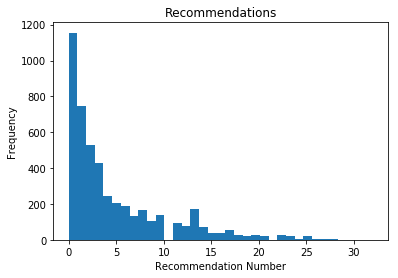

In [205]:


import matplotlib.pyplot as plt
plt.hist(index_match , bins=35)
plt.title("Recommendations")
plt.xlabel("Recommendation Number")
plt.ylabel("Frequency")
plt.show()

In [206]:
sorted_analyst_prob

[[(191458827, 0.61869240998269759),
  (318215316, 0.23528659295666718),
  (698544350, 0.14597363500583679),
  (310294822, 2.0064670035109579e-05),
  (848792669, 8.0722980927734826e-06),
  (535506877, 4.432448941463015e-06),
  (521307710, 2.4970815319850843e-06),
  (311145288, 2.3171786525777422e-06),
  (776883118, 2.1456287098177566e-06),
  (311485742, 1.8328990021231508e-06),
  (330086414, 1.1703059871686625e-06),
  (856895107, 1.148036212766919e-06),
  (324653500, 5.3873105360955277e-07),
  (535902738, 5.3853978395723163e-07),
  (522079805, 4.1004195292299335e-07),
  (544269145, 2.9110477851905933e-07),
  (191918473, 1.7779425103277358e-07),
  (180190019, 1.7751837873861261e-07),
  (329338909, 1.7545002243785364e-07),
  (329808695, 1.594130744150948e-07),
  (668401755, 1.261741430143437e-07),
  (787489756, 1.124405986478307e-07),
  (956519110, 1.0996937608461318e-07),
  (535567176, 1.0512495905649771e-07),
  (291180362, 1.0475059384187985e-07),
  (648708485, 1.0387619377451608e-07),


In [207]:
Y_test

480562    698544350
312227    328874185
313557    544269145
478686    535567176
367825    668401755
397936    184831246
342676    178412342
139959    850772930
297566    668401755
194506    698544350
107773    850772930
131723    850772930
121690    698544350
334665    311485742
126194    850772930
204732    956519110
478224    631444387
160824    178412342
353499    328453238
418048    178412342
119193    698544350
282000    180190019
350747    698544350
359463    698544350
315735    328453238
175403    956519110
428036    535506877
70947     776883118
344212    328874185
401630    328453238
            ...    
224407    544269145
248239    850772930
151846    787489756
485822    191458827
277120    956519110
348142    535902738
239173    956519110
137583    850772930
170695    180190019
107251    631444387
216030    180190019
281206    698544350
377922    329808695
133200    631444387
487075    328874185
148019    535567176
389674    648708485
228759    648708485
88453     319749875


In [208]:
print(len(Y_test))
print(len(sorted_analyst_prob))

4754
4754


In [209]:
Y_test.index

Int64Index([480562, 312227, 313557, 478686, 367825, 397936, 342676, 139959,
            297566, 194506,
            ...
            265768, 194893, 134156, 205172, 153496, 382580, 373643, 249376,
            150252,  81968],
           dtype='int64', length=4754)

In [241]:
ticket_index = Y_test.index.tolist()
#for i in range(len(ticket_index)):
for i in range(1):
    t_i = ticket_index[i]
    analyst_prob = sorted_analyst_prob[i]

0


In [274]:
print(ticket_index[0])
print(sorted_analyst_prob[0])

480562
[(191458827, 0.61869240998269759), (318215316, 0.23528659295666718), (698544350, 0.14597363500583679), (310294822, 2.0064670035109579e-05), (848792669, 8.0722980927734826e-06), (535506877, 4.432448941463015e-06), (521307710, 2.4970815319850843e-06), (311145288, 2.3171786525777422e-06), (776883118, 2.1456287098177566e-06), (311485742, 1.8328990021231508e-06), (330086414, 1.1703059871686625e-06), (856895107, 1.148036212766919e-06), (324653500, 5.3873105360955277e-07), (535902738, 5.3853978395723163e-07), (522079805, 4.1004195292299335e-07), (544269145, 2.9110477851905933e-07), (191918473, 1.7779425103277358e-07), (180190019, 1.7751837873861261e-07), (329338909, 1.7545002243785364e-07), (329808695, 1.594130744150948e-07), (668401755, 1.261741430143437e-07), (787489756, 1.124405986478307e-07), (956519110, 1.0996937608461318e-07), (535567176, 1.0512495905649771e-07), (291180362, 1.0475059384187985e-07), (648708485, 1.0387619377451608e-07), (850772930, 9.8586647959080462e-08), (631444

In [224]:
#sorted_analyst_prob[1][0][1]
sorted_analyst_prob[0]

[(191458827, 0.61869240998269759),
 (318215316, 0.23528659295666718),
 (698544350, 0.14597363500583679),
 (310294822, 2.0064670035109579e-05),
 (848792669, 8.0722980927734826e-06),
 (535506877, 4.432448941463015e-06),
 (521307710, 2.4970815319850843e-06),
 (311145288, 2.3171786525777422e-06),
 (776883118, 2.1456287098177566e-06),
 (311485742, 1.8328990021231508e-06),
 (330086414, 1.1703059871686625e-06),
 (856895107, 1.148036212766919e-06),
 (324653500, 5.3873105360955277e-07),
 (535902738, 5.3853978395723163e-07),
 (522079805, 4.1004195292299335e-07),
 (544269145, 2.9110477851905933e-07),
 (191918473, 1.7779425103277358e-07),
 (180190019, 1.7751837873861261e-07),
 (329338909, 1.7545002243785364e-07),
 (329808695, 1.594130744150948e-07),
 (668401755, 1.261741430143437e-07),
 (787489756, 1.124405986478307e-07),
 (956519110, 1.0996937608461318e-07),
 (535567176, 1.0512495905649771e-07),
 (291180362, 1.0475059384187985e-07),
 (648708485, 1.0387619377451608e-07),
 (850772930, 9.85866479590